In [2]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from scipy import stats
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam, Adamax, Adadelta
from tensorflow.keras.layers import LeakyReLU, PReLU, Dropout
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import missingno as msno

In [5]:
raw_data = pd.read_csv('/kaggle/input/new-loan-tin100/SBAnational.csv', delimiter=',', low_memory=False)

In [6]:
raw_data.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


In [8]:
raw_data.describe(include='object').T

,count,unique,top,freq
Name,899150,779583,SUBWAY,1269
City,899134,32581,LOS ANGELES,11558
State,899150,51,CA,130619
Bank,897605,5802,BANK OF AMERICA NATL ASSOC,86853
BankState,897598,56,CA,118116
ApprovalDate,899164,9859,7-Jul-93,1131
ApprovalFY,899164,52,2005,77525
RevLineCr,894636,18,N,420288
LowDoc,896582,8,N,782822
ChgOffDate,162699,6448,13-Mar-10,734


<AxesSubplot:>

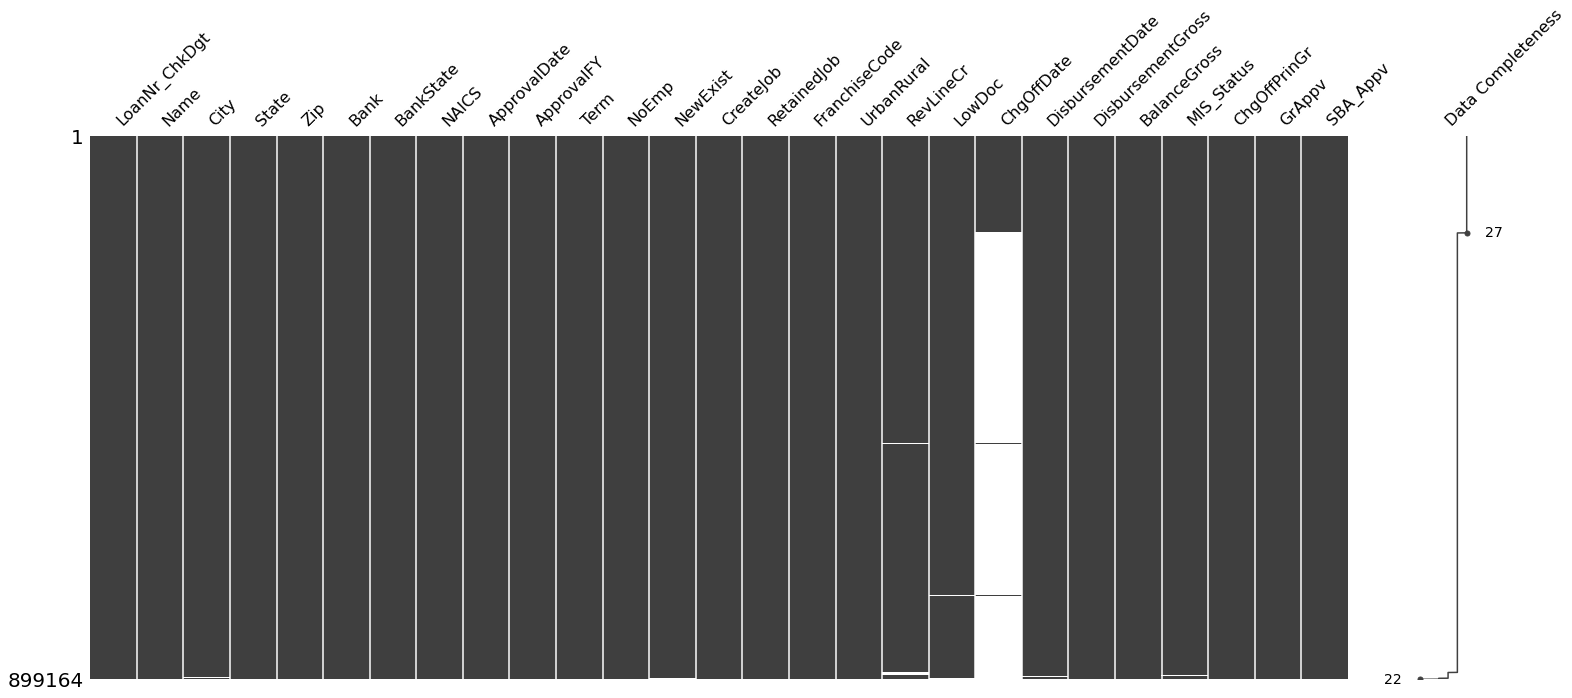

In [9]:
msno.matrix(raw_data, labels=True, sort='descending')

In [19]:
def wrangle(df):
  # copy
  cleaned_df = df.copy(deep = True)
 
  ## Remove symbols
  list_s = ['DisbursementGross','GrAppv','SBA_Appv']

  for colm in list_s:
    cleaned_df[colm] = cleaned_df[colm].str.replace('[$,]', '').astype(float)
   
       
  ## List of unnecessary, inconsistent and leaky variables
  list_un = ['LoanNr_ChkDgt','Name','City','State', 'Zip','Bank',
              'BankState','NAICS','ApprovalDate','NewExist', 'DisbursementDate',
              'ApprovalFY', 'FranchiseCode','ChgOffPrinGr','ChgOffDate',
              'BalanceGross','RevLineCr','LowDoc','CreateJob','RetainedJob','UrbanRural'
              ]
    
  # Create a Real State variable 
  list_real = []
    
  for real in cleaned_df['Term']:
    if real >=240:
      real = 1
    else:
      real = 0

    list_real.append(real)
        
  cleaned_df['RealEstate'] = list_real
   


  # SBA's Guaranteed Portion of Approved Loan
  cleaned_df['portion'] = cleaned_df['SBA_Appv']/ cleaned_df['GrAppv']
   
   
  # New target variable
  cleaned_df['Default'] = (cleaned_df['MIS_Status'] == 'CHGOFF').astype(int)
   
  #Remove old target variable
  list_un.append('MIS_Status')
   
  # Drop columns
  cleaned_df.drop(columns = list_un, inplace = True)

  # drop miss_values
  cleaned_df.dropna(inplace = True)
     
  return cleaned_df


In [20]:
df_tran = wrangle(raw_data)
print(df_tran.shape)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == "__main__":


(899164, 8)


In [21]:
df_tran.head(10)

,Term,NoEmp,DisbursementGross,GrAppv,SBA_Appv,RealEstate,portion,Default
0,84,4,60000.0,60000.0,48000.0,0,0.80000,0
1,60,2,40000.0,40000.0,32000.0,0,0.80000,0
2,180,7,287000.0,287000.0,215250.0,0,0.75000,0
3,60,2,35000.0,35000.0,28000.0,0,0.80000,0
4,240,14,229000.0,229000.0,229000.0,1,1.00000,0
5,120,19,517000.0,517000.0,387750.0,0,0.75000,0
6,45,45,600000.0,600000.0,499998.0,0,0.83333,1
7,84,1,45000.0,45000.0,36000.0,0,0.80000,0
8,297,2,305000.0,305000.0,228750.0,1,0.75000,0
9,84,3,70000.0,70000.0,56000.0,0,0.80000,0


In [22]:
df_tran.describe().round(2)

,Term,NoEmp,DisbursementGross,GrAppv,SBA_Appv,RealEstate,portion,Default
count,899164.00,899164.00,899164.00,899164.00,899164.00,899164.00,899164.00,899164.00
mean,110.77,11.41,201154.02,192686.98,149488.79,0.17,0.71,0.18
std,78.86,74.11,287640.85,283263.39,228414.56,0.37,0.17,0.38
min,0.00,0.00,0.00,200.00,100.00,0.00,0.03,0.00
25%,60.00,2.00,42000.00,35000.00,21250.00,0.00,0.50,0.00
50%,84.00,4.00,100000.00,90000.00,61250.00,0.00,0.75,0.00
75%,120.00,10.00,238000.00,225000.00,175000.00,0.00,0.85,0.00
max,569.00,9999.00,11446325.00,5472000.00,5472000.00,1.00,1.00,1.00


### Splitting the data into train and test

In [23]:
training_data = df_tran.sample(frac=0.8, random_state=21)
testing_data = df_tran.drop(training_data.index)

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 719331
No. of testing examples: 179833


In [24]:
# Code for scikit-learn based model

X = training_data.drop(["Default"], axis=1)
y = training_data["Default"]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.3, random_state=21)

print("X_train: ",X_train.shape)
print("X_test: ",X_test.shape)
print("y_train: ",y_train.shape)
print("y_test: ",y_test.shape)

X_train:  (503531, 7)
X_test:  (215800, 7)
y_train:  (503531,)
y_test:  (215800,)


In [26]:
# Scaling the data with StandardScaler()

sc = StandardScaler()
sc.fit(X_train)


# Transform (standardise) both X_train and X_test with mean and STD from 
# training data

X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

### ANN with Keras

In [27]:
# Code for creating and training a ANN with Keras

model = models.Sequential([
    layers.Dense(1024, activation ="PReLU"),
    layers.Dense(512, activation ="PReLU"),
    layers.Dropout(0.1),
    layers.Dense(256, activation ="PReLU"),
    layers.Dropout(0.1),
    layers.Dense(128, activation = "PReLU"),
    layers.Dense(64, activation = "PReLU"),
    layers.Dense(1, activation = "sigmoid")])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

callback = EarlyStopping(monitor='loss', patience=5)

# Fit model (in the same manner as you would with scikit-learn)
model.fit(X_train_sc, 
          y_train,
          epochs=100,
          callbacks=callback,
          batch_size=256,
          validation_split=0.3)


2023-01-17 14:52:25.593730: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 14:52:25.595162: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 14:52:25.742720: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 14:52:25.744245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 14:52:25.745411: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Epoch 1/100
1377/1377 [==============================] - 10s 5ms/step - loss: 0.3222 - accuracy: 0.8567 - val_loss: 0.2795 - val_accuracy: 0.8739
Epoch 2/100
1377/1377 [==============================] - 7s 5ms/step - loss: 0.2817 - accuracy: 0.8723 - val_loss: 0.2641 - val_accuracy: 0.8808
Epoch 3/100
1377/1377 [==============================] - 7s 5ms/step - loss: 0.2643 - accuracy: 0.8829 - val_loss: 0.2525 - val_accuracy: 0.8873
Epoch 4/100
1377/1377 [==============================] - 7s 5ms/step - loss: 0.2571 - accuracy: 0.8858 - val_loss: 0.2485 - val_accuracy: 0.8877
Epoch 5/100
1377/1377 [==============================] - 6s 5ms/step - loss: 0.2547 - accuracy: 0.8870 - val_loss: 0.2457 - val_accuracy: 0.8923
Epoch 6/100
1377/1377 [==============================] - 7s 5ms/step - loss: 0.2502 - accuracy: 0.8890 - val_loss: 0.2569 - val_accuracy: 0.8860
Epoch 7/100
1377/1377 [==============================] - 6s 5ms/step - loss: 0.2462 - accuracy: 0.8904 - val_loss: 0.2412 - val_a

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              9216      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               525312    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8

### Saving our best model to not train it every time

In [29]:
model.save("tin100-ann-model.h5") # Saving to a h5 file